In [ ]:
import geopandas as gpd
from google.colab import drive
import os, time, random, numpy as np, geopandas as gpd, pandas as pd
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import unary_union
from pyproj import Transformer


drive.mount('/content/drive')

shp_path =  '/content/drive/MyDrive/Tesis/Datos/v_camineria_nacional.shp'
roads = gpd.read_file(shp_path)
roads = roads[roads.geometry.is_valid].reset_index(drop=True)
roads_valid = roads[roads.geometry.is_valid].reset_index(drop=True)
route_9 = roads[roads['numero'] == 9]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Identificacion de paradas

In [ ]:
import requests, time, os
API_KEY = "GOOGLE_MAPS_API_KEY"

def iniciar_sesion(API_KEY):

  session = requests.Session()

def test_static_maps_key(lat, lon, zoom=20, size=(640, 640), scale=1, maptype="satellite",
                         api_key=API_KEY, retries=3, backoff=1.5):

    w, h = size
    url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": str(zoom),
        "size": f"{w}x{h}",
        "scale": str(scale),
        "maptype": maptype,
        "key": api_key,
    }
    last = None
    for attempt in range(1, retries+1):
        r = session.get(url, params=params, timeout=30)
        last = r
        if r.status_code == 200 and r.headers.get("content-type","").startswith("image/"):
            return r.content
        time.sleep(backoff ** attempt)
    raise RuntimeError(f"HTTP {last.status_code}: {last.text[:200]}")

def iter_lines(g):
    if isinstance(g, LineString):
        yield g
    elif isinstance(g, MultiLineString):
        for gg in g.geoms:
            if isinstance(gg, (LineString, MultiLineString)):
                yield from iter_lines(gg)
def establecer_parametros():
  STEP_METERS = 50
  ZOOM = 20
  SIZE = (640, 640)
  SCALE = 1
  MAPTYPE = "satellite"
  OUTPUT_DIR = "/content/drive/My Drive/Tesis/Datos/Imagenes_Satelitales_Ruta_9"
  os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
"""
# Muestreo ordenado con deduplicación estable
pts_3857 = []
for line in iter_lines(g3857):
    L = float(line.length)
    dists = np.arange(0, max(L, 1.0), STEP_METERS, dtype=float).tolist()
    if not dists or dists[-1] < L:
        dists.append(L)
    for d in dists:
        pts_3857.append(line.interpolate(d))

to4326 = Transformer.from_crs(3857, 4326, always_xy=True)

coords = []
seen = set()
for p in pts_3857:
    lat = to4326.transform(p.x, p.y)[1]
    lon = to4326.transform(p.x, p.y)[0]
    key = (round(lat, 6), round(lon, 6))
    if key not in seen:
        seen.add(key)
        coords.append((lat, lon))

print(f"Puntos a descargar: {len(coords)} (paso ~{STEP_METERS} m)")

# 4) Descarga con tu función test_static_maps_key
def outname(i):
    return os.path.join(OUTPUT_DIR, f"ruta9_pt_{i:05d}_z{ZOOM}.png")

# =============================
# >>> NUEVO: índice (DataFrame)
# =============================
rows = []
for i, (lat, lon) in enumerate(coords, start=1):
    path = outname(i)
    rows.append({
        "idx": i,
        "filename": f"ruta9_pt_{i:05d}_z{ZOOM}.png",
        "path": path,
        "lat": lat,
        "lon": lon,
        "exists_before": os.path.exists(path),
        "downloaded": False,   # se actualizará durante/tras la descarga
        "error": ""            # se completa si falla
    })

df = pd.DataFrame(rows).set_index("idx").sort_index()

remaining = [(i, lat, lon) for i, (lat, lon) in enumerate(coords, start=1)
             if not df.loc[i, "exists_before"]]

print(f"Total puntos: {len(coords)} | Faltan: {len(remaining)}")

errores = []
for i, lat, lon in remaining:
    try:
        img = test_static_maps_key(
            lat, lon,
            zoom=ZOOM, size=SIZE, scale=SCALE, maptype=MAPTYPE
        )
        with open(outname(i), "wb") as f:
            f.write(img)
        df.loc[i, "downloaded"] = True
        if i % 100 == 0:
            print(f"✅ Guardadas hasta el índice {i}")
    except Exception as e:
        msg = str(e)[:200]
        errores.append((i, lat, lon, msg))
        df.loc[i, "error"] = msg
        print(f"❌ {i} ({lat:.6f},{lon:.6f}) -> {msg}")
    # ~1–2 req/s con jitter para evitar 429
    time.sleep(0.25 + random.random() * 0.25)

# Marcar como descargado todo lo que efectivamente exista (por si algo preexistía)
df["downloaded"] = df["downloaded"] | (~df["exists_before"] & df["path"].apply(os.path.exists))

print("Hecho. Carpeta:", OUTPUT_DIR)
if errores:
    print(f"Quedaron {len(errores)} errores (podés reintentar solo esos).")

# =============================
# >>> NUEVO: guardar índice CSV + GeoJSON
# =============================
index_csv    = os.path.join(OUTPUT_DIR, f"ruta9_index_z{ZOOM}.csv")
index_geojson= os.path.join(OUTPUT_DIR, f"ruta9_index_z{ZOOM}.geojson")

# GeoDataFrame con puntos (WGS84)
gdf = gpd.GeoDataFrame(
    df.reset_index(),
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

df.to_csv(index_csv, index=False)
# GeoJSON (compatible con QGIS/Kepler/Leaflet)
gdf.to_file(index_geojson, driver="GeoJSON")

print(f"🗂️ Índice CSV guardado en: {index_csv}")
print(f"🗺️ GeoJSON guardado en:    {index_geojson}")
"""

'\n# Muestreo ordenado con deduplicación estable\npts_3857 = []\nfor line in iter_lines(g3857):\n    L = float(line.length)\n    dists = np.arange(0, max(L, 1.0), STEP_METERS, dtype=float).tolist()\n    if not dists or dists[-1] < L:\n        dists.append(L)\n    for d in dists:\n        pts_3857.append(line.interpolate(d))\n\nto4326 = Transformer.from_crs(3857, 4326, always_xy=True)\n\ncoords = []\nseen = set()\nfor p in pts_3857:\n    lat = to4326.transform(p.x, p.y)[1]\n    lon = to4326.transform(p.x, p.y)[0]\n    key = (round(lat, 6), round(lon, 6))\n    if key not in seen:\n        seen.add(key)\n        coords.append((lat, lon))\n\nprint(f"Puntos a descargar: {len(coords)} (paso ~{STEP_METERS} m)")\n\n# 4) Descarga con tu función test_static_maps_key\ndef outname(i):\n    return os.path.join(OUTPUT_DIR, f"ruta9_pt_{i:05d}_z{ZOOM}.png")\n\n# =============================\n# >>> NUEVO: índice (DataFrame)\n# =============================\nrows = []\nfor i, (lat, lon) in enumerate(co

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
"""import os, glob, shutil
from google.colab import drive
import uuid
from roboflow import Roboflow
from PIL import Image, ImageDraw, ImageFont
from shapely.geometry import Polygon, Point, box
from shapely.ops import unary_union

def parametros_modelo():
  CONF_PARADAS_MIN   = 55   # % mínimo para que el modelo de paradas reporte (igual que venías usando)
  CONF_SEGURA_UMBRAL =  75 # % mínimo para clasificar como "segura" (entre las válidas)
  ROUTE_BUFFER_PX    = 10   # px de tolerancia alrededor de la ruta para filtrar paradas "encima" de la ruta
  OVERLAP_PCT        = 30   # NMS overlap (Roboflow)

# =========================
# 1) Montar Drive y carpetas
# =========================

drive.mount('/content/drive')
base_dir      = '/content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_9'
seguras_dir   = os.path.join(base_dir, "paradas_seguras")
noseguras_dir = os.path.join(base_dir, "paradas_no_seguras")
os.makedirs(seguras_dir, exist_ok=True)
os.makedirs(noseguras_dir, exist_ok=True)

# =========================
# 2) Cargar modelos Roboflow
# =========================
rf = Roboflow(api_key="ROBOFLOW_API_KEY")

# Modelo de paradas
project_paradas = rf.project("tesis-um-n0pxr")
model_paradas   = project_paradas.version(6).model

# Modelo de ruta (detección o segmentación)
project_ruta = rf.project("identificador-de-rutas-qnmf6")
model_ruta   = project_ruta.version(2).model
"""

In [ ]:
# =========================
# 3) Utilitarios de geometría
# =========================
def pred_to_polygon(pred, buffer_px=0):
    """
    Convierte una predicción de Roboflow a un polígono de shapely.
    - Si es segmentación: usa pred['points'].
    - Si es detección: arma un rectángulo desde x,y,width,height.
    Aplica buffer (px) si se desea ensanchar.
    """
    if 'points' in pred and pred['points']:
        # Polígono (segmentación)
        pts = [(p['x'], p['y']) for p in pred['points']]
        poly = Polygon(pts)
    else:
        # Bounding box (detección)
        x, y = pred['x'], pred['y']
        w, h = pred['width'], pred['height']
        poly = box(x - w/2, y - h/2, x + w/2, y + h/2)
    if buffer_px and buffer_px > 0:
        # buffer en pixeles (en coords de imagen ya son px)
        poly = poly.buffer(buffer_px)
    return poly

def union_polygons(preds, buffer_px=0):
    """Crea la unión geométrica de las regiones detectadas/segmentadas de la ruta."""
    if not preds:
        return None
    polys = []
    for pr in preds:
        try:
            polys.append(pred_to_polygon(pr, buffer_px=buffer_px))
        except Exception:
            # Si una máscara viene malformada, la saltamos
            continue
    if not polys:
        return None
    return unary_union(polys)

def draw_bbox(draw, pred, outline=(0,255,0), width=3, label=None):
    """Dibuja una caja del pred (x,y,w,h) con un posible label."""
    x, y = pred['x'], pred['y']
    w, h = pred['width'], pred['height']
    x0, y0 = int(x - w/2), int(y - h/2)
    x1, y1 = int(x + w/2), int(y + h/2)
    draw.rectangle([x0, y0, x1, y1], outline=outline, width=width)
    if label:
        # Texto sobre el bbox
        try:
            # Colab suele no tener fuentes TTF por defecto; usamos la default.
            draw.text((x0+4, y0+4), label, fill=outline)
        except Exception:
            pass

def overlay_polygon(image, poly, outline=(255,255,255), fill_alpha=50, width=2):
    """
    Dibuja una región poligonal (o multipolígono) sobre la imagen con relleno semitransparente.
    """
    if poly is None or poly.is_empty:
        return image
    # Creamos overlay con alpha
    overlay = image.copy()
    overlay = overlay.convert("RGBA")
    tmp = Image.new("RGBA", overlay.size, (0,0,0,0))
    draw_tmp = ImageDraw.Draw(tmp, "RGBA")

    def _draw_single(p):
        try:
            exterior = [(int(x), int(y)) for x, y in p.exterior.coords]
            draw_tmp.polygon(exterior, fill=(255,255,255,fill_alpha), outline=outline+(255,))
            # holes
            for hole in p.interiors:
                hole_pts = [(int(x), int(y)) for x, y in hole.coords]
                draw_tmp.polygon(hole_pts, fill=(0,0,0,0), outline=outline+(255,))
        except Exception:
            pass

    if poly.geom_type == "Polygon":
        _draw_single(poly)
    elif poly.geom_type == "MultiPolygon":
        for p in poly.geoms:
            _draw_single(p)

    # Unir overlay
    out = Image.alpha_composite(overlay, tmp)
    return out.convert("RGB")


In [ ]:
# =========================
# 4) Procesamiento por imagen
# =========================
imgs = glob.glob(os.path.join(base_dir, '*.png'))

# Create a temporary directory for processing
temp_dir = "/content/temp_images"
os.makedirs(temp_dir, exist_ok=True)

for img_path in imgs:
    fname = os.path.basename(img_path)

    # Convert image to RGB and save temporarily
    try:
        im = Image.open(img_path).convert("RGB")
        temp_img_path = os.path.join(temp_dir, fname)
        im.save(temp_img_path)
    except Exception as e:
        print(f"Error converting image {fname}: {e}")
        continue


    # --- 4.1) Paradas
    result_paradas = model_paradas.predict(
        temp_img_path, confidence=CONF_PARADAS_MIN, overlap=OVERLAP_PCT
    ).json()
    preds_paradas = result_paradas.get('predictions', [])

    # Si no hay paradas pasamos a la siguiente imagen
    if not preds_paradas:
        print(f"{fname}: ⚠️ no segura (sin paradas)")
        os.remove(temp_img_path)
        continue

    # --- 4.2) Ruta (detección/segmentación)
    result_ruta = model_ruta.predict(
        temp_img_path, confidence=30
    ).json()
    preds_ruta = result_ruta.get('predictions', [])

    # Unión de polígonos de la ruta (buffer configurable)
    ruta_union = union_polygons(preds_ruta, buffer_px=ROUTE_BUFFER_PX)

    # --- 4.3) Filtrado de paradas: dentro de la ruta => falso positivo
    paradas_validas = []
    paradas_filtradas = []
    for p in preds_paradas:
        pt = Point(p['x'], p['y'])
        inside_route = (ruta_union is not None) and ruta_union.contains(pt)
        if inside_route:
            paradas_filtradas.append(p)
        else:
            paradas_validas.append(p)

    # --- 4.4) Anotación manual (verde=válida, rojo=filtrada), ruta en blanco translúcido
    im = Image.open(temp_img_path).convert("RGB") # Open the converted RGB image
    im = overlay_polygon(im, ruta_union, outline=(255,255,255), fill_alpha=40, width=2)
    draw = ImageDraw.Draw(im)

    # Dibujar paradas válidas (verde) y filtradas (rojo)
    for p in paradas_validas:
        conf_pct = round(p['confidence']*100, 1)
        label = f"{p['class']} {conf_pct}%"
        draw_bbox(draw, p, outline=(0,200,0), width=3, label=label)

    for p in paradas_filtradas:
        conf_pct = round(p['confidence']*100, 1)
        label = f"FILTRADA {conf_pct}%"
        draw_bbox(draw, p, outline=(220,0,0), width=3, label=label)

    # Footer con conteos
    txt = f"Válidas: {len(paradas_validas)} | Filtradas por ruta: {len(paradas_filtradas)}"
    try:
        draw.text((10, 10), txt, fill=(255,255,0))
    except Exception:
        pass

    # --- 4.5) Regla de clasificación: usa SOLO las válidas
    if paradas_validas:
        max_conf_valida = max(p['confidence'] for p in paradas_validas) * 100.0
        if max_conf_valida > CONF_SEGURA_UMBRAL:
            im.save(os.path.join(seguras_dir, fname))
            print(f"{fname}: ✅ segura | {txt} | max válida={max_conf_valida:.1f}%")
        else:
            im.save(os.path.join(noseguras_dir, fname))
            print(f"{fname}: ⚠️ no segura (baja confianza válida) | {txt} | max válida={max_conf_valida:.1f}%")
    else:
        # No quedó ninguna válida después del filtro de ruta
        im.save(os.path.join(noseguras_dir, fname))
        print(f"{fname}: ⚠️ no segura (todas filtradas por ruta) | {txt}")

    # Clean up temporary file
    os.remove(temp_img_path)

# Clean up temporary directory
os.rmdir(temp_dir)

NameError: name 'glob' is not defined

# Sistema identificado

In [ ]:
# --- Setup básico ---
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, math
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN

# --- Parámetros / Paths ---
BASE_DIR = "/content/drive/MyDrive/Tesis/Datos/Imagenes_Satelitales_Ruta_9"
SAFE_DIR = f"{BASE_DIR}/paradas_no_seguras"                          # carpeta con imágenes "seguras"
CSV_PATH = f"{BASE_DIR}/ruta9_index_z20.csv"                      # tu CSV con filename/lat/lon
OUTPUT_DIR = f"{BASE_DIR}/paradas_seguras_outputs"                # carpeta para salidas tabulares/geojson
DEDUP_IMG_DIR = f"{BASE_DIR}/paradas_seguras_dedup"               # carpeta con imágenes deduplicadas
EPS_METERS = 100.0                                                # umbral de distancia en metros para considerar duplicado
EPSG_URUGUAY_UTM21S = 32721                                       # proyección métrica

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DEDUP_IMG_DIR, exist_ok=True)

# --- 1) Leer CSV con index de imágenes (filename, lat, lon) ---
df = pd.read_csv(CSV_PATH)
df['filename'] = df['filename'].str.replace("ruta5", "ruta9", regex=False)

# sanity check columnas mínimas
req_cols = {"filename","lat","lon"}
missing = req_cols - set(df.columns.str.lower())
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}. Columnas encontradas: {df.columns.tolist()}")

# Normalizar nombres de columnas por las dudas
df = df.rename(columns={"Latitude":"lat","Lat":"lat","Lon":"lon","Longitude":"lon","FileName":"filename","file_name":"filename"})

# --- 2) Listar solamente las imágenes que están en paradas_seguras ---
safe_files = [f for f in os.listdir(SAFE_DIR) ]

safe_df = df[df["filename"].isin(safe_files)].copy()

print(f"Imágenes seguras en carpeta: {len(safe_files)}")
print(f"Coincidencias filename en CSV: {len(safe_df)}")
if len(safe_df) == 0:
    raise RuntimeError("No se encontraron coincidencias entre filenames en paradas_seguras y el CSV. Revisar nombres/paths.")

# --- 3) GeoDataFrame WGS84 y proyectar a metros (EPSG:32721) ---
gdf_wgs = gpd.GeoDataFrame(
    safe_df,
    geometry=[Point(xy) for xy in zip(safe_df["lon"].values, safe_df["lat"].values)],
    crs=4326
)
gdf_m = gdf_wgs.to_crs(EPSG_URUGUAY_UTM21S)

# --- 4) DBSCAN en metros ---
coords_m = np.column_stack([gdf_m.geometry.x.values, gdf_m.geometry.y.values])
labels = DBSCAN(eps=EPS_METERS, min_samples=1, metric="euclidean").fit(coords_m).labels_
gdf_m["cluster_id"] = labels
gdf_m["cluster_size"] = gdf_m.groupby("cluster_id")["cluster_id"].transform("size")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imágenes seguras en carpeta: 108
Coincidencias filename en CSV: 108


# Optimizacion

In [ ]:
escuelas_shp_path =  '/content/drive/MyDrive/Tesis/Datos/ceip-escuela/CEIP.shp'
escuelas = gpd.read_file(escuelas_shp_path)
escuelas = escuelas.to_crs(epsg=32721)
escuelas = escuelas[~escuelas.geometry.isnull()]
escuelas = escuelas[escuelas["Area"] == "RURAL"] #solo considerar escuelas rurales
route_9_ = route_9.to_crs(epsg=32721)
route9_buffer = route_9_.buffer(6000)
route9_buffer = gpd.GeoDataFrame(geometry=route9_buffer, crs=route_9_.crs)
escuelas_cercanas = gpd.sjoin(escuelas, route9_buffer, how="inner", predicate='intersects')

#display(escuelas_cercanas.head())
print(f"Numeros de escuelas rurales cercas a ruta 9: {len(escuelas_cercanas)}")
route_9 = roads[roads['numero'] == 9].geometry
ruta9 = route_9.geometry.to_list()
def intersecciones (roads, ruta9):
  intersections_list = []
  for index, row in roads.iterrows():
      geometri = row['geometry']
      if not geometri in ruta9:
        for tramo in ruta9:
          intersection = geometri.intersection(tramo)
          if not intersection.is_empty:
            intersections_list.append(intersection)
            break
  intersections_gdf = gpd.GeoDataFrame(geometry=intersections_list, crs=roads.crs)
  return intersections_gdf
intersections_gdf = intersecciones(roads, ruta9)


Numeros de escuelas rurales cercas a ruta 9: 389


In [ ]:
PATH_LOCALIDADES = "/content/drive/MyDrive/Tesis/Datos/merged_localidades.csv"
loc = pd.read_csv(PATH_LOCALIDADES)
loc = loc.rename(columns={"size":"poblacion"})
loc.dropna(subset=['LON', 'LAT'], inplace=True)
gdf_loc_wgs = gpd.GeoDataFrame(
    loc,
    geometry=gpd.points_from_xy(loc["LON"], loc["LAT"]),
    crs=4326
)
gdf_loc = gdf_loc_wgs.to_crs(epsg=32721)

localidades_cercanas =  gpd.sjoin(gdf_loc, route9_buffer, how="inner", predicate='intersects')

In [ ]:
# @title Poi's finales (escuelas, intersecciones y localidades)
# Ensure intersections_gdf only contains Point geometries by taking the centroid
intersections_gdf_points = intersections_gdf.geometry.apply(lambda geom: geom.centroid if not geom.is_empty else None).dropna()
intersections_gdf_points = gpd.GeoDataFrame(geometry=intersections_gdf_points, crs=intersections_gdf.crs)

# Convert intersections_gdf_points to the same CRS as the other GeoDataFrames
intersections_gdf_points = intersections_gdf_points.to_crs(epsg=32721)

# Concatenate all point geometries into gdf_POI
gdf_POI = pd.concat([localidades_cercanas, escuelas_cercanas, intersections_gdf_points], ignore_index=True)
gdf_POI = gpd.GeoDataFrame(gdf_POI, geometry=gdf_POI.geometry, crs=localidades_cercanas.crs)

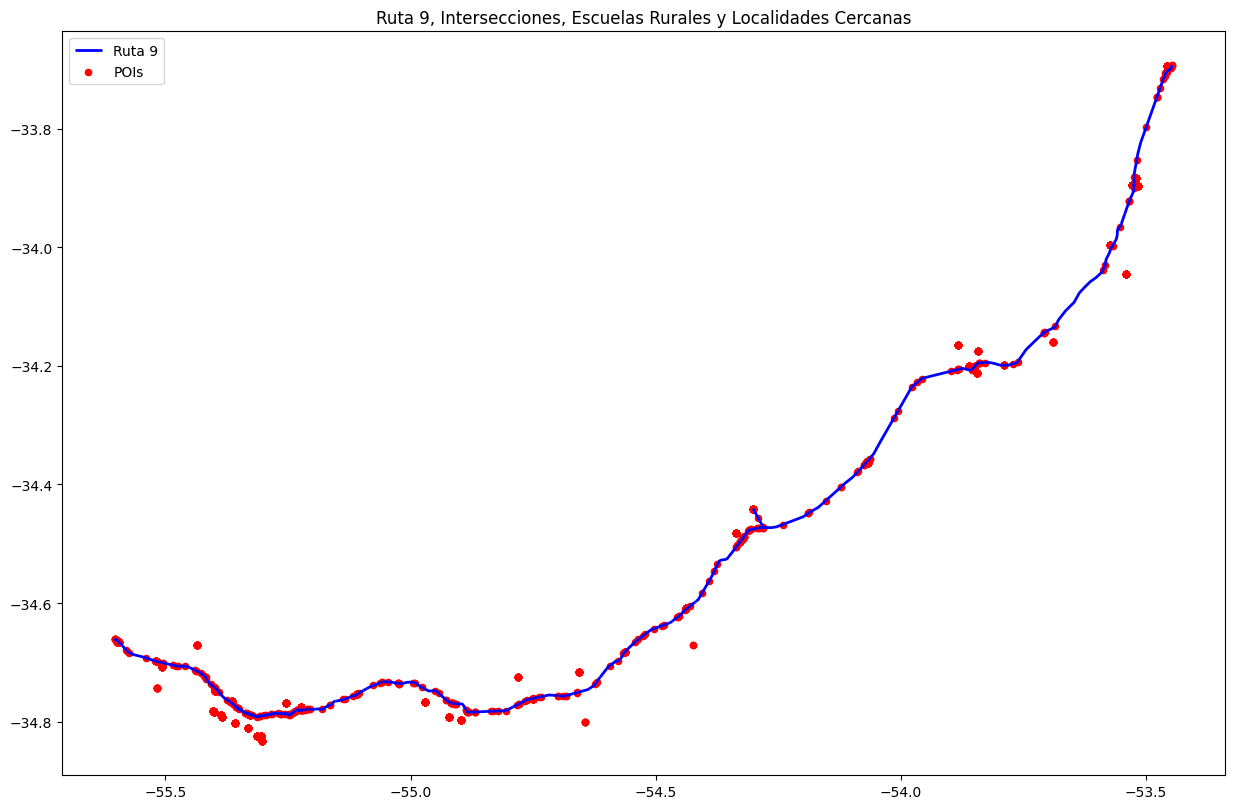

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Convert route_9 to the common projected CRS (EPSG:32721) for plotting.
# The 'route_9' variable at this point is a GeoSeries with CRS 4326.
route_9_projected_for_plot = route_9.to_crs(4326)
route_9.plot(ax=ax, color='blue', linewidth=2, label='Ruta 9')

# gdf_POI is already in EPSG:32721, so no further conversion is needed for plotting.

POIs = gdf_POI.to_crs(4326)
POIs.plot(ax=ax, color='red', markersize=20, label='POIs')

ax.legend()
ax.set_title('Ruta 9, Intersecciones, Escuelas Rurales y Localidades Cercanas')
plt.show()

#Optimizacion

In [ ]:
# @title Utilidades
import math
from dataclasses import dataclass
from typing import Tuple, Optional
from shapely.ops import unary_union, linemerge, snap
from shapely.geometry import LineString, MultiLineString, Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans

def _merged_route_line(roads: gpd.GeoDataFrame,S = 100)-> list:
    u = unary_union(roads.geometry.values)
    u = snap(u, u, S)       # cierra micro-gaps reales
    merged = linemerge(u)
    parts = merged.geoms if isinstance(merged, MultiLineString) else [merged]
    lines = sorted(list(merged.geoms), key=lambda g: (g.bounds[1], g.bounds[0]))
    return lines

def points_every(line, step) -> list:
    L = line.length
    d = 0.0
    pts = []
    while d <= L:
        pts.append(line.interpolate(d))
        d += step
    return pts

def _snap_point_to_line_and_m(point: Point, line) -> Tuple[Point, float]:
    """
    Snaps a point to a LineString or MultiLineString and returns the snapped point
    and the m-value (distance along the line from the start).
    """
    from shapely.ops import nearest_points

    if isinstance(line, LineString):
        snapped = nearest_points(point, line)[0]
        coords = list(line.coords)
        dists = [0.0]
        for i in range(1, len(coords)):
            dists.append(dists[-1] + Point(coords[i-1]).distance(Point(coords[i])))
        total_len = dists[-1]
        min_dist = float("inf"); seg_idx = 0
        for i in range(1, len(coords)):
            seg = LineString([coords[i-1], coords[i]])
            d = snapped.distance(seg)
            if d < min_dist:
                min_dist = d; seg_idx = i
        a = Point(coords[seg_idx-1]); b = Point(coords[seg_idx])
        ab = np.array([b.x - a.x, b.y - a.y])
        ap = np.array([snapped.x - a.x, snapped.y - a.y])
        seg_len = np.linalg.norm(ab)
        t = 0.0 if seg_len == 0 else np.clip(np.dot(ap, ab) / (seg_len**2), 0, 1)
        m = dists[seg_idx-1] + t * seg_len
        return snapped, m

    elif isinstance(line, MultiLineString):
        min_dist = float("inf")
        best_snapped = None
        best_m = 0.0
        total_len_so_far = 0.0

        for segment in line.geoms:
            try:
                snapped_seg, m_seg = _snap_point_to_line_and_m(point, segment)
                dist_to_segment = point.distance(snapped_seg)

                if dist_to_segment < min_dist:
                    min_dist = dist_to_segment
                    best_snapped = snapped_seg
                    # Calculate m-value along the *entire* MultiLineString
                    best_m = total_len_so_far + m_seg
            except Exception:
                # Handle cases where snapping to a small segment might fail
                pass
            total_len_so_far += segment.length

        if best_snapped is None:
             # If snapping failed for all segments, return a default or raise error
             # For now, return the original point and 0 m-value as a fallback
             return point, 0.0 # Or raise an informative error

        return best_snapped, best_m

    else:
        raise TypeError("Input geometry must be a LineString or MultiLineString")


# --- Candidate generation ---
#espaciar cada 3 km

def make_candidates_along_route(roads: gpd.GeoDataFrame, spacing_m: int = 3000):
    route_line_segments = _merged_route_line(roads)
    pts = []
    Distancia = 0
    for tramo in route_line_segments:
        if Distancia > spacing_m:
          puntos = points_every(tramo, spacing_m)
          for punto in puntos:
              pts.append(punto)
          Distancia = 0
        else:
          Distancia += tramo.length

    return gpd.GeoDataFrame({"cand_id": range(len(pts))}, geometry=pts, crs=roads.crs)
                      ##################################################################
                      ###################### hasta aca funciona  #######################
                      ##################################################################
def expand_candidates(candidates, roads, expand_m: int = 500):
    route_line_segments = _merged_route_line(roads)
    new_pts = []
    # Consider a small buffer for proximity check
    buffer_distance = 1.0 # meters, adjust as needed

    for p in candidates.geometry:
        for tramo in route_line_segments:
            # Check if the point is within a small buffer of the line segment
            if p.within(tramo.buffer(buffer_distance)):
                _, m = _snap_point_to_line_and_m(p, tramo)
                for delta in (-expand_m, 0, +expand_m):
                    md = max(0, min(tramo.length, m + delta))
                    new_pts.append(tramo.interpolate(md))
                # Once a segment is found, no need to check others for this point
                break

    return gpd.GeoDataFrame(geometry=new_pts, crs=roads.crs).drop_duplicates(ignore_index=True)



# --- Clustering ---

"""
def kmeans_centers(demand_pts: gpd.GeoDataFrame, k: int):
    X = np.c_[demand_pts.geometry.x, demand_pts.geometry.y]
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_
    counts = pd.Series(labels).value_counts().sort_index().to_numpy()
    return gpd.GeoDataFrame({"weight": counts}, geometry=[Point(xy) for xy in centers], crs=demand_pts.crs)
"""
def kmeans_centers(demand_pts: gpd.GeoDataFrame, k: int):
    X = np.c_[demand_pts.geometry.x, demand_pts.geometry.y]
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_

    # cuenta puntos en cada cluster, incluyendo los vacíos
    counts = np.bincount(labels, minlength=k)

    return gpd.GeoDataFrame(
        {"weight": counts},
        geometry=[Point(xy) for xy in centers],
        crs=demand_pts.crs
    )


# --- WPDM scoring ---
####### REVISAR
####### Por que proyecta en la ruta las ciudades, los candidatos ya van a estar en la ruta
import numpy as np
import pandas as pd
from pyproj import CRS


def wpdm_scores(candidates, centers, shortlist_k: int = 3, rank_weights=(1.0, 0.5, 0.2)):
    """
    candidates: GeoSeries (puntos) o array de floats (distancias euclídeas si no es Geo)
    centers: GeoDataFrame con columnas: geometry (Point) y weight (float)
    """
    shortlist_k = int(shortlist_k)
    if shortlist_k < 1:
        raise ValueError("shortlist_k debe ser >= 1")

    # Asegurar pesos suficientes (relleno con 0: más allá de los 3 primeros no suma)
    rweights = np.array(rank_weights, dtype=float)
    if len(rweights) < shortlist_k:
        rweights = np.pad(rweights, (0, shortlist_k - len(rweights)), constant_values=0.0)

    scores = np.zeros(len(candidates), dtype=float)

    use_geo = hasattr(candidates, "distance") and hasattr(centers, "geometry")
    center_weights = np.asarray(centers["weight"], dtype=float)

    for i, w in enumerate(center_weights):
        if use_geo:
            dists = np.asarray(candidates.distance(centers.geometry.iloc[i]))
        else:
            # si no es Geo, asumir candidatos y centers son arrays/series numéricas comparables
            dists = np.abs(np.asarray(candidates) - np.asarray(centers.iloc[i]))

        # Elegir los k más cercanos y ordenarlos por distancia
        k = min(shortlist_k, len(dists))
        idx = np.argpartition(dists, k-1)[:k]
        idx = idx[np.argsort(dists[idx])]
        scores[idx] += w * rweights[:k]

    return pd.DataFrame({"score": scores})

def select_top_n_with_min_spacing(
    candidates: gpd.GeoDataFrame,
    scores: pd.DataFrame,
    n: int,
    min_spacing_m: float = 100.0,
    score_col: str = "score",
    metric_crs: str = "EPSG:32721",  # UTM 21S (Uruguay): distancias en metros
):
    # --- Validaciones ---
    if not isinstance(candidates, gpd.GeoDataFrame):
        raise TypeError("candidates debe ser un GeoDataFrame.")
    if score_col not in scores.columns:
        raise ValueError(f"'{score_col}' no existe en scores.")
    if len(scores) != len(candidates):
        raise ValueError("candidates y scores deben tener el mismo largo (1:1).")
    if candidates.crs is None:
        raise ValueError("El GeoDataFrame no tiene CRS. Define uno (WGS84, etc.).")

    # Deben ser puntos
    if not (candidates.geometry.geom_type == "Point").all():
        raise ValueError("La geometría debe ser de tipo Point en todas las filas.")

    # --- Trabajar en metros ---
    crs_obj = CRS.from_user_input(candidates.crs)
    g = candidates
    if crs_obj.is_geographic:
        # reproyectamos a CRS en metros (por defecto UTM 21S)
        g = candidates.to_crs(metric_crs)

    # --- Selección ávida por score con espaciamiento mínimo ---
    order = (
        pd.DataFrame({"idx": np.arange(len(g)), "score": scores[score_col].to_numpy()})
        .dropna(subset=["score"])
        .sort_values("score", ascending=False)["idx"]
        .to_list()
    )

    chosen = []
    for idx in order:
        if len(chosen) >= n:
            break
        geom = g.geometry.iloc[idx]
        # distancia mínima al conjunto ya elegido
        if not chosen:
            chosen.append(idx)
            continue
        dmin = min(geom.distance(g.geometry.iloc[j]) for j in chosen)
        if dmin >= float(min_spacing_m):
            chosen.append(idx)

    out = candidates.iloc[chosen].copy()
    out[score_col] = scores.iloc[chosen][score_col].to_numpy()
    return out.sort_values(score_col, ascending=False).reset_index(drop=True)

RI_TABLE = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45,
    10: 1.49, 11: 1.51, 12: 1.48, 13: 1.56, 14: 1.57, 15: 1.59
}

def build_pairwise_matrix(items, comparisons, check_scale=True):
    labels = list(items)
    n = len(labels)
    idx = {name: k for k, name in enumerate(labels)}
    A = np.ones((n, n), dtype=float)
    for (i, j), v in comparisons.items():
        if i not in idx or j not in idx:
            raise ValueError(f"Unknown item in comparison: {(i,j)}")
        if v <= 0:
            raise ValueError("Comparison values must be positive.")
        if check_scale and not (1/9 <= v <= 9):
            print(f"Warning: value {v} for ({i},{j}) is outside Saaty 1..9 (or reciprocal). Proceeding.")
        A[idx[i], idx[j]] = v
        A[idx[j], idx[i]] = 1.0 / v
    np.fill_diagonal(A, 1.0)
    return A, labels

def ahp_weights(A, method="eigen"):
    A = np.asarray(A, dtype=float)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    n = A.shape[0]

    if method == "eigen":
        vals, vecs = np.linalg.eig(A)
        idx = np.argmax(vals.real)
        w = vecs[:, idx].real
        w = np.abs(w)
    elif method == "geom":
        w = np.prod(A, axis=1) ** (1.0 / n)
    else:
        raise ValueError("method must be 'eigen' or 'geom'")

    w = w / w.sum()

    Aw = A @ w
    lambda_max = float((Aw / w).mean())
    CI = (lambda_max - n) / (n - 1) if n > 1 else 0.0
    RI = RI_TABLE.get(n, RI_TABLE[max(k for k in RI_TABLE if k <= n)])
    CR = CI / RI if RI > 0 else 0.0
    return {"weights": w, "lambda_max": lambda_max, "CI": CI, "CR": CR}

# Criterios
labels = ["POI_number", "Stops_spacing", "Stop_POI_distance"]

# Comparaciones por pares (escala de Saaty)
comparisons = {
    ("POI_number", "Stops_spacing"): 3,    # POI moderadamente > spacing
    ("POI_number", "Stop_POI_distance"): 2,# POI fuertemente > dist
    ("Stops_spacing", "Stop_POI_distance"): 0.5  # spacing ligeramente > dist
}

A, _ = build_pairwise_matrix(labels, comparisons)
res = ahp_weights(A, method="eigen")
pesos = np.round(res["weights"])
print("Matriz A:\n", np.round(A, 3))
print("Pesos:", np.round(res["weights"], 6))
print("lambda_max:", round(res["lambda_max"], 6), "CI:", round(res["CI"], 6), "CR:", round(res["CR"], 6))

Matriz A:
 [[1.    3.    2.   ]
 [0.333 1.    0.5  ]
 [0.5   2.    1.   ]]
Pesos: [0.539615 0.163424 0.296961]
lambda_max: 3.009203 CI: 0.004601 CR: 0.007933


In [ ]:
# @title Criterio AHP
@dataclass
class AHPWeights:
    poi_number: float = 0.539615
    stop_spacing: float = 0.163424
    poi_distance: float = 0.296961

def evaluate_stops_ahp(stops, roads, pois, weights=AHPWeights()):
    # Get the merged route geometry (can be LineString or MultiLineString)
    route_geometry = unary_union(roads.geometry.values)

    # Calculate m-values by snapping each stop to the route geometry
    mvals = stops.geometry.apply(lambda p: _snap_point_to_line_and_m(p, route_geometry)[1]).sort_values().to_numpy()

    spacings = np.diff(mvals) if len(mvals)>1 else [0]
    sp_full = np.r_[spacings[0], (spacings[:-1]+spacings[1:])/2.0, spacings[-1]] if len(mvals)>1 else [0]*len(mvals)
    #distancias entre paradas
    #distancias a mirar en el futuro, y adaptarlas segun poblacion
    spacing_score = pd.Series([1.0 if 2000<d<=15000 else 0.5 if d<=25000 else 0.2 for d in sp_full], index=stops.index)
    counts = stops.buffer(5000).apply(lambda b: pois.within(b).sum())
    #cantidad de localidades de cercanas
    poi_num_score = counts.apply(lambda c: 0.3 if c<=1 else 0.6 if c<=3 else 0.8 if c<=10 else 1.0)
    poi_dist_score = []
    #distancia promedio a las localidades mas cercanas
    for _, s in stops.iterrows():
        d = pois.distance(s.geometry)
        mask = d <= 5000
        if mask.any():
            avg = d[mask].mean()
            sc = 1.0 if avg<=2000 else 0.7 if avg<=3500 else 0.5
        else: sc = 0.5
        poi_dist_score.append(sc)
    poi_dist_score = pd.Series(poi_dist_score, index=stops.index)
    #calcula la metrica
    total = (weights.poi_number*poi_num_score +
             weights.stop_spacing*spacing_score +
             weights.poi_distance*poi_dist_score)
    df = pd.DataFrame({"poi_num": poi_num_score, "spacing": spacing_score,
                       "poi_dist": poi_dist_score, "total_score": total})
    df.attrs["overall_mean"] = float(total.mean())
    return df

def optimize_single_corridor(roads, demand_pts, pois, n_new_stops, k_clusters=None,
                             spacing_m=3000, expand_m=1500, shortlist_k=3, min_spacing_m=100):
    candidates = make_candidates_along_route(roads, spacing_m)
    print(f"Candidates: {len(candidates)}")
    candidates2 = expand_candidates(candidates, roads, expand_m)
    print(f"2 Candidates: {len(candidates2)}")
    if k_clusters is None:
        k_clusters = min(20, max(5, int(np.sqrt(len(demand_pts)))))
    centers = kmeans_centers(demand_pts, k=k_clusters)
    sc = wpdm_scores(candidates2, centers, shortlist_k) # Removed 'roads' argument
    new_stops = select_top_n_with_min_spacing(candidates2, sc, n=n_new_stops, min_spacing_m=min_spacing_m)
    print(f"paradas finales: {len(new_stops)}")
    return new_stops, sc

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


roads_valid = roads[roads.geometry.is_valid].reset_index(drop=True)
roads_valid = roads_valid.to_crs(4326)

# Paleta de 4 azules distintos
azules = sns.color_palette("Blues", 4).as_hex()

def graficar_paradas(gdf, etiqueta = None, titulo = None):
  fig, ax = plt.subplots(figsize=(8,8))

  roads_valid[roads_valid["categoria"]=="CORREDOR INTERNACIONAL"].plot(
      ax=ax, color=azules[3], linewidth=2, label="Corredor Internacional"
  )
  roads_valid[roads_valid["categoria"]=="RUTA PRIMARIA"].plot(
      ax=ax, color=azules[2], linewidth=1.8, label="Ruta Primaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA SECUNDARIA"].plot(
      ax=ax, color=azules[1], linewidth=1.5, label="Ruta Secundaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA TERCIARIA"].plot(
      ax=ax, color=azules[0], linewidth=1.2, label="Ruta Terciaria"
  )


  # Plot the bus stops
  gdf.plot(ax=ax, color='red', markersize=20, label='Paradas Ruta 5')

  ax.set_title(titulo)
  ax.set_xlabel("Lon")
  ax.set_ylabel("Lat")
  plt.legend()
  plt.show()


In [ ]:
!pip install optuna

In [ ]:
# @title Optimizacion (Yu)
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
route_9_m   = route_9.to_crs(32721)
gdf_POI_m   = gdf_POI.to_crs(32721)
POIs_m      = POIs.to_crs(32721)
Tipo_ahp = "mean"
Costo_parada = 0.8
def objective(trial: optuna.Trial):
    # --- ESPACIO RURAL ---
    spacing_m     = trial.suggest_int("spacing_m", 2000, 40000)      # separación base de candidatos
    expand_m      = trial.suggest_int("expand_m", min(1000,spacing_m//3), min(3500, spacing_m//2))         # micro-ajuste local
    shortlist_k   = trial.suggest_categorical("shortlist_k", [2,3,4,5,6,7])
 #   min_spacing_m = trial.suggest_int("min_spacing_m", 2000, 1000)
    paradas = trial.suggest_int("paradas", 100, 350)

    # k_clusters moderado (rural): entre ~sqrt(N) N
    lo_k = np.sqrt(len(gdf_POI))
    hi_k = len(gdf_POI)//2
    k_clusters   = trial.suggest_int("k_clusters", lo_k, hi_k)

    new_stops_try, wpdm_try = optimize_single_corridor(
        roads=route_9_m,
        demand_pts=POIs_m,
        pois=POIs_m,           # si por ahora POIs=demanda como proxy, mantenemos consistencia
        n_new_stops=paradas,
        k_clusters=k_clusters,
        spacing_m=spacing_m,
        expand_m=expand_m,
        shortlist_k=shortlist_k,
        min_spacing_m=100
    )
    eval_try = evaluate_stops_ahp(new_stops_try, route_9_m, POIs_m)
    if Tipo_ahp == "mean":
      score_mean = float(eval_try["total_score"].mean())
    elif Tipo_ahp == "median":
      score_mean = float(eval_try["total_score"].median())
    elif Tipo_ahp == "sum":
      score_mean = float(eval_try["total_score"].sum() - len(new_stops_try)*Costo_parada)

    return score_mean
def Optimizar_Yu():
  study = optuna.create_study(
      direction="maximize",
      sampler=TPESampler(seed=42),
      pruner=MedianPruner(n_warmup_steps=10),
      study_name="ruta9_rural_wpdm_ahp"
  )

  study.optimize(objective, n_trials=300, show_progress_bar=True)

In [ ]:
#Tipo_ahp = "sum"
#Optimizar_Yu()

Optimizacion por suma

Trial 278 finished with value: 7.175554199999993

parameters: {'spacing_m': 2648, 'expand_m': 1131, 'shortlist_k': 5, 'paradas': 143, 'k_clusters': 321}. Best is trial 278 with value: 7.175554199999993.


In [ ]:
route_9_m   = route_9.to_crs(32721)
gdf_POI_m   = gdf_POI.to_crs(32721)
POIs_m      = POIs.to_crs(32721)

new_stops_sum, wpdm_try = optimize_single_corridor(
        roads=route_9_m,
        demand_pts=POIs_m,
        pois=POIs_m,           # si por ahora POIs=demanda como proxy, mantenemos consistencia
        n_new_stops=143,
        k_clusters=321,
        spacing_m= 2648,
        expand_m=1131,
        shortlist_k=5,
        min_spacing_m=100
    )
eval_opt_sum = evaluate_stops_ahp(new_stops_sum, route_9_m, POIs_m)

Candidates: 114
2 Candidates: 281


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (314) found smaller than n_clusters (321). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


paradas finales: 143


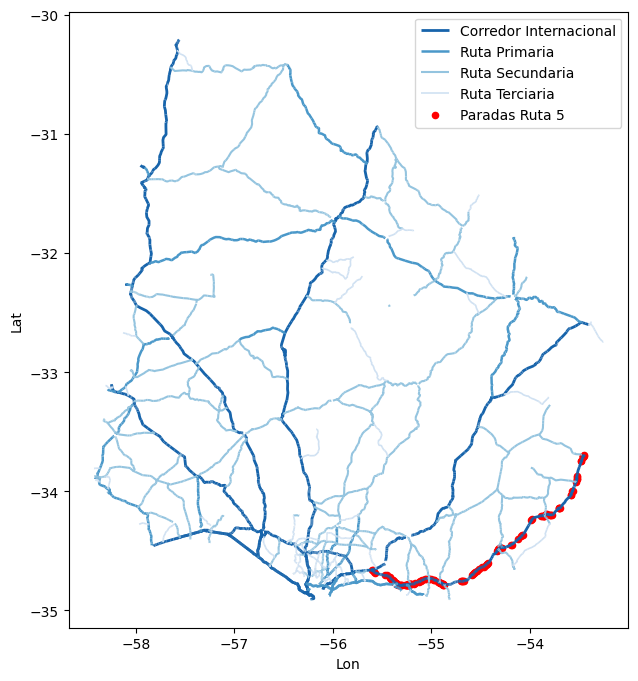

In [ ]:
graficar_paradas(new_stops_sum.to_crs(4326),etiqueta= "Paradas" )


In [ ]:
len(eval_opt_sum['total_score'])

143

In [ ]:
#Tipo_ahp = "mean"
#Optimizar_Yu()

Optimizacion por media


Trial 169 finished with value: 0.8620156076923078

parameters: {'spacing_m': 36358, 'expand_m': 1273, 'shortlist_k': 5, 'paradas': 240, 'k_clusters': 389}. Best is trial 169 with value: 0.8620156076923078.

In [ ]:
route_9_m   = route_9.to_crs(32721)
gdf_POI_m   = gdf_POI.to_crs(32721)
POIs_m      = POIs.to_crs(32721)

new_stops, wpdm_try = optimize_single_corridor(
        roads=route_9_m,
        demand_pts=POIs_m,
        pois=POIs_m,           # si por ahora POIs=demanda como proxy, mantenemos consistencia
        n_new_stops=240,
        k_clusters=389,
        spacing_m= 36358,
        expand_m=1273,
        shortlist_k=5,
        min_spacing_m=100
    )
eval_try = evaluate_stops_ahp(new_stops, route_9_m, POIs_m)

Candidates: 12
2 Candidates: 28
paradas finales: 26


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (314) found smaller than n_clusters (389). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


# Optimizacion usando algoritmo genetico (N=120)

In [ ]:
# @title Optimizacion usando algoritmo genetico y 120 paradas

!pip install deap --quiet


import numpy as np, random, multiprocessing as mp
from functools import lru_cache
from deap import base, creator, tools, algorithms

# --- Hiperparámetros (ajustables) ---
N = 120              # número de paradas
dmin = 100       # separación mínima (m)
POP = 120           # tamaño población
GEN = 60            # generaciones máx
CX_P = 0.7          # prob cruce
MUT_P = 0.3         # prob mutación
TOUR = 3            # torneo
EARLY_NI = 10       # cortar si no mejora en 10 gens
candidates = make_candidates_along_route(route_9_m, dmin)
candidates = candidates.to_crs(32721)





In [ ]:
# @title algoritmo genetico
# ====== PRE-COMPUTOS ======
ALL_IDX = np.arange(len(candidates), dtype=int)

def _precompute_too_close_neighbors(candidates, dmin):
    from sklearn.neighbors import KDTree
    xy = np.array([(p.x, p.y) for p in candidates.geometry.to_numpy()], dtype=float)
    tree = KDTree(xy)
    idxs = tree.query_radius(xy, r=dmin)
    out = []
    for i, arr in enumerate(idxs):
        s = set(arr.tolist())
        s.discard(i)
        out.append(s)
    return out
too_close = _precompute_too_close_neighbors(candidates, dmin)
too_close_sets = [set(s) for s in too_close]

# ====== FITNESS con caché y penalización ======
try:
    creator.FitnessMax
except AttributeError:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

@lru_cache(maxsize=10000)
def _fitness_from_tuple(sol_tuple):
    idx = np.fromiter(sol_tuple, dtype=int)
    chosen = set(idx.tolist())
    # Chequeo O(N * grado) muy rápido
    for i in idx:
        if too_close_sets[i] & chosen:
            return -1e9  # penalización dura: evita llamar AHP
    # Solo si es factible, llamamos a tu función cara:
    sc = evaluate_stops_ahp(candidates.iloc[idx], roads=route_9_m, pois=POIs_m)
    return float(np.mean(sc["total_score"]))

def evaluate_individual(ind):
    return (_fitness_from_tuple(tuple(ind)),)

# ====== OPERADORES FEASIBLES ======
def init_individual():
    ind, available = [], set(ALL_IDX.tolist())
    while len(ind) < N and available:
        i = random.sample(list(available), 1)[0]
        ind.append(i)
        # bloquear vecinos a < dmin
        available -= (too_close_sets[i] | {i})
    # reparación greedy si faltan genes
    if len(ind) < N:
        rem = list(set(ALL_IDX) - set(ind))
        random.shuffle(rem)
        for j in rem:
            if all((j not in too_close_sets[k]) for k in ind):
                ind.append(j)
                if len(ind) == N: break
    return creator.Individual(sorted(ind))

def cx_repair(ind1, ind2):
    # mezcla por unión parcial y repara factibilidad
    pool = list(set(ind1) | set(random.sample(ind2, k=N//2)))
    child = []
    used = set()
    for i in sorted(pool):
        if all((i not in too_close_sets[j]) for j in child):
            child.append(i); used.add(i)
        if len(child) == N: break
    if len(child) < N:
        rest = list(set(ALL_IDX) - used)
        random.shuffle(rest)
        for i in rest:
            if all((i not in too_close_sets[j]) for j in child):
                child.append(i)
                if len(child) == N: break
    ind1[:] = sorted(child)
    # hijo 2: simétrico pero con roles invertidos
    pool2 = list(set(ind2) | set(random.sample(ind1, k=N//2)))
    child2, used2 = [], set()
    for i in sorted(pool2):
        if all((i not in too_close_sets[j]) for j in child2):
            child2.append(i); used2.add(i)
        if len(child2) == N: break
    if len(child2) < N:
        rest2 = list(set(ALL_IDX) - used2)
        random.shuffle(rest2)
        for i in rest2:
            if all((i not in too_close_sets[j]) for j in child2):
                child2.append(i)
                if len(child2) == N: break
    ind2[:] = sorted(child2)
    return ind1, ind2

def mut_targeted(ind, k=None):
    if k is None: k = max(1, N//10)
    cur = set(ind)
    # remover hasta k genes más conflictivos
    for _ in range(k):
        conflicts = [(i, len(too_close_sets[i] & cur)) for i in list(cur)]
        i_bad, cmax = max(conflicts, key=lambda t: t[1])
        if cmax == 0: break
        cur.remove(i_bad)
    # rellenar con índices que no choquen
    pool = list(set(ALL_IDX) - cur)
    random.shuffle(pool)
    for i in pool:
        if len(cur) >= N: break
        if all((i not in too_close_sets[j]) for j in cur):
            cur.add(i)
    ind[:] = sorted(list(cur))[:N]
    return (ind,)

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", cx_repair)
toolbox.register("mutate", mut_targeted, k=max(1, N//10))
toolbox.register("select", tools.selTournament, tournsize=TOUR)
toolbox.register("evaluate", evaluate_individual)

# Paralelización
pool = mp.Pool(processes=max(1, mp.cpu_count()-1))
toolbox.register("map", pool.map)
# ====== BUCLE EVOLUTIVO con early stopping ======
pop = toolbox.population(n=POP)
hof = tools.HallOfFame(5)
best, no_improve = -np.inf, 0

# ====== CHECKPOINT ======
import pickle, gzip, os
from pathlib import Path

CKPT = Path("/content/drive/MyDrive/Tesis/checkpoints/ga_ruta9_checkpoint.pkl.gz")

def _serialize_pop(pop):
    # Lista de (genes, fitness)
    return [ (list(ind), float(ind.fitness.values[0]) if ind.fitness.valid else None) for ind in pop ]

def _deserialize_pop(serialized):
    pop = []
    for genes, fit in serialized:
        ind = creator.Individual(list(genes))
        if fit is not None:
            ind.fitness.values = (fit,)
        pop.append(ind)
    return pop

def save_ckpt(gen, pop, hof, best, no_improve, rng_state, np_rand_state):
    # Ensure the directory exists
    CKPT.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "gen": gen,
        "pop": _serialize_pop(pop),
        "hof": _serialize_pop(list(hof)),
        "best": float(best),
        "no_improve": int(no_improve),
        "rng_state": rng_state,
        "np_rand_state": np_rand_state,
        # opcional: cache de fitness si la querés persistir
        # "_fitness_from_tuple_cache": _fitness_from_tuple.cache_info()  # solo info
    }
    with gzip.open(CKPT, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_ckpt():
    with gzip.open(CKPT, "rb") as f:
        payload = pickle.load(f)
    pop = _deserialize_pop(payload["pop"])
    hof_list = _deserialize_pop(payload["hof"])
    hof = tools.HallOfFame(maxlen=max(1, len(hof_list)))
    for ind in hof_list: hof.insert(ind)
    return (payload["gen"], pop, hof, payload["best"], payload["no_improve"],
            payload["rng_state"], np_rand_state)

def optimizar_GA(CKPT):
  start_gen = 0
  if CKPT.exists():
      (start_gen, pop, hof, best, no_improve, rng_state, np_rand_state) = load_ckpt()
      random.setstate(rng_state)
      np.random.set_state(np_rand_state)
      print(f"Reanudando desde gen {start_gen}, best={best:.6f}")
  else:
      pop = toolbox.population(n=POP)
      hof = tools.HallOfFame(5)
      best, no_improve = -np.inf, 0
      # eval inicial si querés arrancar con fitness válidos
      fits = list(toolbox.map(toolbox.evaluate, pop))
      for ind, fit in zip(pop, fits): ind.fitness.values = fit
      hof.update(pop)
      best = hof[0].fitness.values[0]
      save_ckpt(0, pop, hof, best, no_improve, random.getstate(), np.random.get_state())
      print(f"Inicio en gen 0, best={best:.6f}")

  # ====== BUCLE EVOLUTIVO con checkpoint por generación ======
  for gen in range(start_gen + 1, GEN + 1):
      offspring = tools.selTournament(pop, len(pop), tournsize=TOUR)
      offspring = list(map(creator.Individual, [list(ind) for ind in offspring]))
      offspring = algorithms.varAnd(offspring, toolbox, cxpb=CX_P, mutpb=MUT_P)
      fits = list(toolbox.map(toolbox.evaluate, offspring))
      for ind, fit in zip(offspring, fits): ind.fitness.values = fit

      pop = tools.selBest(pop + offspring, POP)
      hof.update(pop)
      cur = hof[0].fitness.values[0]

      print(f"Gen {gen} | best={cur:.6f}")
      if cur > best: best, no_improve = cur, 0
      else: no_improve += 1

      # Guardar SIEMPRE al final de la generación
      save_ckpt(gen, pop, hof, best, no_improve, random.getstate(), np.random.get_state())

      if no_improve >= EARLY_NI:
          print(f"Early stop en gen {gen} (sin mejora {EARLY_NI} gens).")
          break

  # ====== FIN ======
  best_idx = hof[0]
  best_score = float(best)
  best_solution = candidates.iloc[best_idx].copy()
  print("Mejor score:", best_score)

In [ ]:
#optimizar_GA(CKPT)

# Graficas

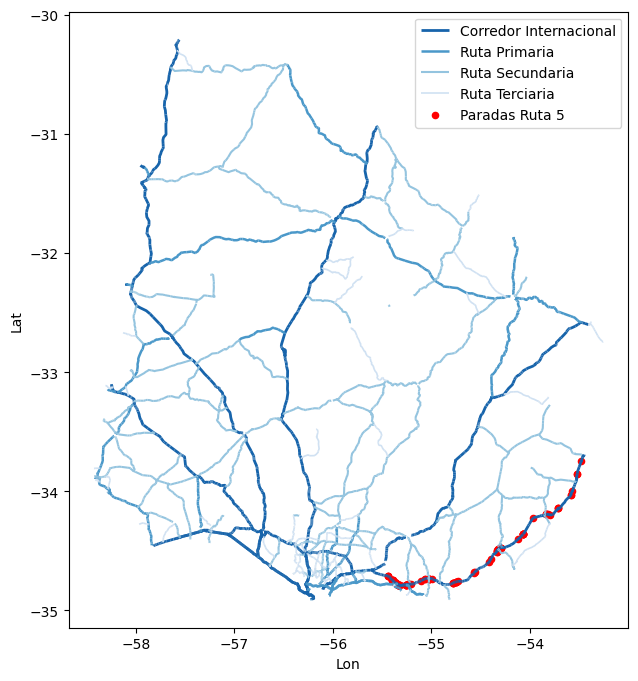

/tmp/ipython-input-3817516598.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counts = stops.buffer(5000).apply(lambda b: pois.within(b).sum())


,poi_num,spacing,poi_dist,total_score
148,0.3,0.5,0.5,0.392077
293,0.3,0.5,0.5,0.392077
382,0.3,0.5,0.5,0.392077
512,0.3,0.5,0.5,0.392077
513,0.3,0.5,0.5,0.392077
...,...,...,...,...
7063,0.3,0.5,0.5,0.392077
7356,0.3,0.5,0.5,0.392077
7371,0.3,0.5,0.5,0.392077
7373,0.3,0.5,0.5,0.392077


In [ ]:
graficar_paradas(gdf_wgs)
eval_paradas_original = evaluate_stops_ahp(gdf_wgs, route_9_m, POIs_m)
eval_paradas_original

In [ ]:
print( "P prime de sistema de paradas",eval_paradas_original['total_score'].sum() - len(eval_paradas_original)*0.8)
print( "P prime de sistema de paradas",eval_opt_sum['total_score'].sum() - len(eval_opt_sum)*0.8)


P prime de sistema de paradas -44.055684
P prime de sistema de paradas 7.175554199999993


In [ ]:
eval_paradas_original['total_score'].mean()

In [ ]:
new_stops = new_stops.to_crs(4326)
graficar_paradas(new_stops, "Paradas optimizadas")

In [ ]:
POIs_m = POIs_m.to_crs(4326)
graficar_paradas(POIs_m, "POIs")